Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


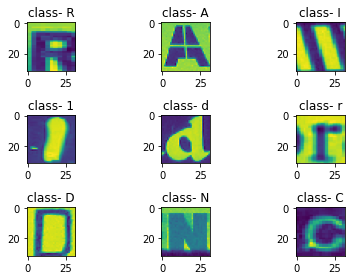

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)
GroundTruth:  I
Predicted:  I
GroundTruth:  R
Predicted:  R
GroundTruth:  A
Predicted:  A
Accuracy of the network on the 4798 test images (2395/4798) : 49.92 %
Accuracy of     0  (7/50) : 14.00 %
Accuracy of     1  (12/49) : 24.49 %
Accuracy of     2  (19/48) : 39.58 %
Accuracy of     3  (15/22) : 68.18 %
Accuracy of     4  (9/26) : 34.62 %
Accuracy of     5  (5/17) : 29.41 %
Accuracy of     6  (9/20) : 45.00 %
Accuracy of     7  (6/13) : 46.15 %
Accuracy of     8  (3/10) : 30.00 %
Accuracy of     9  (6/37) : 16.22 %
Accuracy of     a  (42/154) : 27.27 %
Accuracy of     b  (2/12) : 16.67 %
Accuracy 

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/drive')

train_set_img = []
train_set_label = []

dataset_path = '/content/drive/My Drive/digitAndCharInBothCaseTestDataset32.h5'

train_model = False
save_model = False
load_saved_model = True


def decode_to_labels(train_set_label):
  if train_set_label.item() in range(0,10):
    res = train_set_label.item() + 48
  if train_set_label.item() in range(10,36):
    res = train_set_label.item() + 87
  if train_set_label.item() in range(36,62):
    res = train_set_label.item() + 29
  return res 

def load_dataset():
    global train_set_img, train_set_label
    # train_dataset = h5py.File('/content/drive/My Drive/charRecogTrainingDataset32.h5', 'r')   # training set
    train_dataset = h5py.File(dataset_path, 'r')         # test set
    train_set_img = np.array(train_dataset['trainingset_image'][:]) # train set features
    train_set_label = np.array(train_dataset['trainingset_label'][:]) # train set labels


    A = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    a = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    digit = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    for i in range(0, len(train_set_label)):
      if len(train_set_label[i]) <=1 and train_set_label[i].decode() not in digit:
        if train_set_label[i].decode() in A:
          res = ord(train_set_label[i]) - 29
        elif train_set_label[i].decode() in a:
          res = ord(train_set_label[i]) - 87
        train_set_label = np.where(train_set_label == train_set_label[i], res, train_set_label)
     

    train_set_img = torch.FloatTensor(train_set_img)
    train_set_label = train_set_label.astype(np.int)
    train_set_label = torch.LongTensor(train_set_label)

    # plot img
    rows = 3
    cols = 3
    axes=[]
    fig=plt.figure()

    i =0
    for a in range(rows*cols):
        b = train_set_img[i]
        axes.append( fig.add_subplot(rows, cols, a+1) )

        res = decode_to_labels(train_set_label[i]) 

        subplot_title=('class- '+chr(res))
        axes[-1].set_title(subplot_title)
         
        i+=1
        b = b.squeeze(0)
        b = b.numpy() # pyTorch tensor to numpy
        plt.imshow(b.astype('uint8'))
    fig.tight_layout()    
    plt.show()

load_dataset()


# Define a CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 62)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.size())
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)


### Define a Loss function and optimizer ###

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)


### Train the network ###
def modelTraining():
  loss_values=[]
  for epoch in range(100):  # loop over the dataset multiple times
      running_loss = 0.0
      for i in range(len(train_set_label)):
          # get the inputs
          inputs = train_set_img[i]
          #inputs /= 255.0
          inputs = inputs.unsqueeze(0)

          labels = train_set_label[i]
          labels = torch.tensor([labels])

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)   # forward

          loss = criterion(outputs, labels)
          loss.backward()                             # backward
          optimizer.step()                            # optimize

          # print statistics
          running_loss += loss.item()
          if i % 100 == 99:    # print every 100 mini-batches
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
              loss_values.append(running_loss)
              running_loss = 0.0
  plt.plot(loss_values)
  plt.show()        
        
  print('Finished Training')

if train_model:
  modelTraining()
  
# save trained model:
PATH = '/content/drive/My Drive/digitAndCharacterInBothCaseRecog.pth'

if save_model:
  torch.save(net.state_dict(), PATH)

# load back the saved model
if load_saved_model:
  net = Net()
  net.load_state_dict(torch.load(PATH))

## TEST on only few/single Dataset
test_images = [train_set_img[2], train_set_img[0], train_set_img[1]]
labels = [train_set_label[2],train_set_label[0],train_set_label[1]]
for i, image in enumerate(test_images):
    test_image = image
    test_image = test_image.unsqueeze(0)

    outputs = net(test_image)
    _, predicted = torch.max(outputs, 1)
    
    print('GroundTruth: ', chr(decode_to_labels(torch.tensor(labels[i].numpy()))) )
    print('Predicted: ',  chr(decode_to_labels(torch.tensor(predicted.numpy()[0]))) )


# network performance on the whole dataset
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(train_set_label)):
        images = train_set_img[i]
        images = images.unsqueeze(0)

        labels = train_set_label[i]
        labels = torch.tensor([labels])

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the '+str(len(train_set_label))+' test images (%d/%d) : %.2f %%' % (correct, total ,100 * correct / total))


# accuracy for all classes:
class_correct = list(0. for i in range(62))
class_total = list(0. for i in range(62))
with torch.no_grad():
  for i in range(len(train_set_label)):
        images = train_set_img[i]
        images = images.unsqueeze(0)

        labels = train_set_label[i]
        labels = torch. tensor([labels])

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        c = (predicted == labels).squeeze()
        
        class_correct[labels] += c.item()
        class_total[labels] += 1
        
for i in range(62):
    print('Accuracy of %5s  (%d/%d) : %.2f %%' % (chr(decode_to_labels(torch.tensor(i))), class_correct[i], class_total[i] ,100 * class_correct[i] / class_total[i]))